# SENTIMENT ANALYSIS USING DEEP LEARNING

---

## i. Perkenalan

=================================================

Nama  : Sulthan Fachry Inadamar

=================================================

### Latar Belakang:

Dalam industri perhotelan yang kompetitif, ulasan dan rating dari customer sangat mempengaruhi keputusan calon pengunjung. Ulasan hotel sering kali disertai dengan rating yang memberikan indikasi jelas tentang pengalaman customer. Project ini bertujuan untuk menganalisis ulasan hotel yang diberi rating 1-5, untuk memahami sentimen pelanggan dan memberikan wawasan berharga bagi manajer hotel dalam meningkatkan kualitas layanan.

### Tujuan:

Project ini bertujuan untuk mengembangkan model deep learning yang dapat mengklasifikasikan ulasan hotel berdasarkan rating menjadi kategori sentimen: "Negatif" (1-2), "Netral" (3), dan "Positif" (4-5). Dengan menggunakan teknik NLP dan algoritma classification,  dengan harapan dapat mencapai akurasi tinggi dalam menilai sentimen dari ulasan.

Hasil yang Diharapkan: Project ini dapat menghasilkan model klasifikasi yang efektif dalam menentukan sentimen dari ulasan hotel berdasarkan rating. Dari hasil tersebut diharapkan dapat membantu manajer hotel untuk memahami umpan balik tamu, mengidentifikasi kekuatan dan kelemahan, serta merumuskan strategi untuk meningkatkan pengalaman customer.

---

## ii. Import Libaries

In [1]:
# Downgrade version of TensorFlow and tf-keras

# !pip install --upgrade "tensorflow<2.16" "tf-keras<2.16"

In [2]:
# Import Libraries

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as tf_hub
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense, Dropout, Bidirectional, Reshape
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score, f1_score

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import joblib
import pickle

nltk.download('stopwords')
nltk.download('punkt_tab')


# To Ignore Warning
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fachr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\fachr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


---

## iii. Data Loading

In [3]:
data = pd.read_csv('tripadvisor_hotel_reviews.csv')

data.head(5) # Check 5 data pertama

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [4]:
data.tail(5) # Check 5 data terakhir

,Review,Rating
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1
20490,"people talking, ca n't believe excellent ratin...",2


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


- Kolom review dan rating sudah sesuai data typenya
- Tidak ada missing values
- Ada 20491 data

## iv. EDA

### Missing Value

In [6]:
data.isnull().sum()

Review    0
Rating    0
dtype: int64

- Tidak ada missing value

### Deskripsi kolom rating

In [7]:
data['Rating'].describe()

count    20491.000000
mean         3.952223
std          1.233030
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: Rating, dtype: float64

- Rata-rata kolom rating ada di 3.9

### Distribusi data Rating

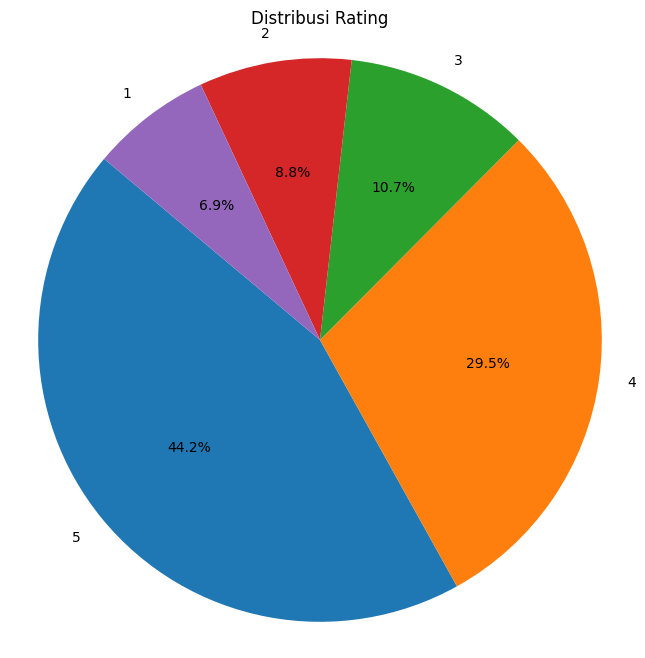

In [8]:
rating = data['Rating'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(rating, labels=rating.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribusi Rating')
plt.axis('equal')  # Agar pie chart berbentuk lingkaran
plt.show()

Dari dataset ini dapat dikonklusikan:

- Rating negatif (1-2) memiliki jumlah ~3000 data
- Rating netral (3) ~2000 data
- Rating positif(4-5) memiliki jumlah ~15000 data

Kesimpulan:
Rating positif lebih dominan daripada rating negatif menandakan data tidak terdistribusi dengan baik atau data tidak balance. Hal ini dapat mempengaruhi kinerja model ketika memprediksi rating dari review yang diberikan oleh user atau pelanggan. Oleh karena itu, kita perlu melakukan databalancing.

## v. Feature Engineering

### Grouping Positive and Negative rating

In [9]:
data = data[data['Rating'] != 3] # Drop rating 3

data['Rating'].value_counts()

Rating
5    9054
4    6039
2    1793
1    1421
Name: count, dtype: int64

- Drop rating 3 karena bersifat netral dan diduga kurang berdampak dalam segi marketing

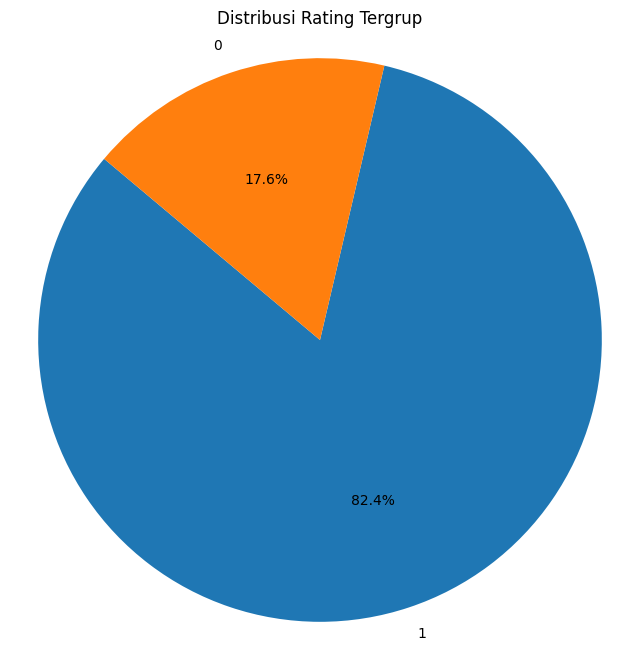

In [10]:
data['Grouped_Rating'] = data['Rating'].replace({1: 0, 2: 0, 4: 1, 5: 1})

# Count the grouped ratings
grouped_counts = data['Grouped_Rating'].value_counts()

# Create a pie chart for the grouped ratings
plt.figure(figsize=(8, 8))
plt.pie(grouped_counts, labels=grouped_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribusi Rating Tergrup')
plt.axis('equal')  # To ensure the pie chart is circular
plt.show()

Berdasarkan grafik diatas:
- Data telah berhasil di grouping Negative (0) dan Positive (1)
- Setelah dilakukan grouping terlihat bahwa data tidak balanced antara data negative (17.6%) dengan data positive (82.4%)

In [11]:
data.head(5)

,Review,Rating,Grouped_Rating
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,0
3,"unique, great stay, wonderful time hotel monac...",5,1
4,"great stay great stay, went seahawk game aweso...",5,1
5,love monaco staff husband stayed hotel crazy w...,5,1


In [12]:
data = data.drop('Rating', axis=1) # Drop kolom rating karena akan menggunakan grouped rating sebagai fitur

In [13]:
data

,Review,Grouped_Rating
0,nice hotel expensive parking got good deal sta...,1
1,ok nothing special charge diamond member hilto...,0
3,"unique, great stay, wonderful time hotel monac...",1
4,"great stay great stay, went seahawk game aweso...",1
5,love monaco staff husband stayed hotel crazy w...,1
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",1
20487,great location price view hotel great quick pl...,1
20488,"ok just looks nice modern outside, desk staff ...",0
20489,hotel theft ruined vacation hotel opened sept ...,0


### Data Balancing

In [14]:
data['Grouped_Rating'].value_counts()

Grouped_Rating
1    15093
0     3214
Name: count, dtype: int64

- Terlihat bahwa rating positif (15093) lebih dominan ketimbang rating negatif (3214)
- Data yang tidak balance dapat mempengaruhi performa model sehingga perlu dilakukan data balancing.

In [15]:
# Definisikan data mayoritas dan minoritas
df_majority = data[data['Grouped_Rating'] == 1]
df_minority = data[data['Grouped_Rating'] == 0]

- Memisahkan data mayoritas dan data minoritas

In [16]:
# Undersampling data yang mayoritas
df_majority_downsampled = resample(df_majority,
                                     replace=False,
                                     n_samples=len(df_minority),
                                     random_state=43)

# concat data yang sudah di sampling dan minoritas
data_balanced = pd.concat([df_majority_downsampled, df_minority])

data_balanced = data_balanced.sample(frac=1, random_state=43).reset_index(drop=True)

# Print hasil
print(data_balanced['Grouped_Rating'].value_counts())

Grouped_Rating
0    3214
1    3214
Name: count, dtype: int64


- Data sudah balanced sesuai dengan data yang minoritas (rating negatif)

In [17]:
data_balanced.head(5)

,Review,Grouped_Rating
0,"disappointing hotel disappointing, idea stayin...",0
1,fabulous girls went new york great stay hotel ...,1
2,"not good motel disappointment, desk clerk not ...",0
3,"absolutely best hotel stayed, stayed resort we...",1
4,"nice room property service horrible, arrived h...",0


### Text preprocessing

In [18]:
# Define stopwords
stop_words = list(set(stopwords.words('english')))

# Define stemming
stemmer = nltk.stem.SnowballStemmer('english')

In [19]:
# Create A Function for Text Preprocessing

def text_preprocessing(text):
  # Case folding
  text = text.lower()

  # Mention removal
  text = re.sub("@[A-Za-z0-9_]+", " ", text)

  # Hashtags removal
  text = re.sub("#[A-Za-z0-9_]+", " ", text)

  # Newline removal (\n)
  text = re.sub(r"\\n", " ",text)

  # Whitespace removal
  text = text.strip()

  # URL removal
  text = re.sub(r"http\S+", " ", text)
  text = re.sub(r"www.\S+", " ", text)

  # Non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc
  text = re.sub("[^A-Za-z\s']", " ", text)

  # Tokenization
  tokens = word_tokenize(text)

  # Stopwords removal
  tokens = [word for word in tokens if word not in stop_words]

  # Stemming
  tokens = [stemmer.stem(word) for word in tokens]

  # Combining Tokens
  text = ' '.join(tokens)

  return text

In [20]:
# Applying Text Preprocessing to the Dataset

data_balanced['Review'] = data_balanced['Review'].apply(lambda x: text_preprocessing(x))

In [21]:
data_balanced.head(5)

,Review,Grouped_Rating
0,disappoint hotel disappoint idea stay renov th...,0
1,fabul girl went new york great stay hotel mela...,1
2,good motel disappoint desk clerk friend help r...,0
3,absolut best hotel stay stay resort week boyfr...,1
4,nice room properti servic horribl arriv hotel ...,0


- Melakukan Text preprocessing karena memiliki peran penting untuk meningkatkan akurasi dan efisiensi model NLP. Tanpa preprocessing yang baik, model mungkin tidak dapat memahami konteks atau makna dari data teks dengan benar.

### Data Splitting

In [22]:
X_train_val, X_test, y_train_val, y_test = train_test_split(data_balanced.Review, data_balanced.Grouped_Rating, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (4643,)
Val Size   :  (820,)
Test Size  :  (965,)


- Train size memiliki 4643 baris data
- Validation size memiliki 820 baris data
- Test Size memiliki 965 baris data

### Encoding

In [23]:
y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)
y_train_ohe

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

## vi. ANN Training

### Text Vectorizing

In [24]:
# Get Vocabularies

Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<4643x17475 sparse matrix of type '<class 'numpy.int64'>'
	with 360094 stored elements in Compressed Sparse Row format>

Berdasarkan syntax diatas:
- Menunjukkan bahwa data X_train terdiri dari 4.643 sampel (ulasan atau dokumen) dan memiliki 17.475 kata unik (fitur atau token) setelah tokenisasi.
- Banyaknya samble bisa bagus untuk menangkap berbagai nuansa dalam data. Namun, dapat juga menyebabkan kompleksitas yang meningkat dan kemungkinan overfitting jika tidak ditangani dengan benar.

In [25]:
# Finding the Number of Vocabs and Max Token Length in One Document

total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  17475
Maximum Sentence Length :  1347 tokens


- Panjang kalimat maksimum sebesar 1.347 token menunjukkan bahwa beberapa dokumen dalam dataset sangat panjang.

In [26]:
# Text Vectorization

text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)) # Only use in Sequential API

text_vectorization.adapt(X_train)

In [27]:
# Example Result

## Document example
print('Document example')
print(data_balanced.Review[0])
print('')

## Result of Text Vectorization
print('Result of Text Vectorization')
print(text_vectorization([data_balanced.Review[0]]))
print('Vector size : ', text_vectorization([data_balanced.Review[0]]).shape)

Document example
disappoint hotel disappoint idea stay renov th centuri convent charm n't expect renov modern asian flair stay tradit old world italian charm hotel hotel surpris breakfast sub par say parti end walk coupl door cafe cross fast food quikimart buy cappucinno hotel restaur includ cappucinno breakfast pay extra n't good room spacious particular european standard bit shabbi bathroom tini appoint worst question neighborhood desk advis night singl femal safe hotel privledg gym instead workout room walk gym nervous gym provid water towel young men lift weight friend women felt quit conspicu place rooftop love time tri lock n't open desk help spoke english beauti help rememb room number love choos hotel adequ place park suitcas hour sleep place want linger soak ambianc laptop check wireless access conveni check email

Result of Text Vectorization
tf.Tensor([[122   2 122 ...   0   0   0]], shape=(1, 1347), dtype=int64)
Vector size :  (1, 1347)


In [28]:
# View the Top 20 Tokens (Sorted by the Highest Frequency of Appearance)

text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'hotel',
 'room',
 'stay',
 'nt',
 'great',
 'staff',
 'night',
 'day',
 'good',
 'time',
 'servic',
 'locat',
 'nice',
 'food',
 'like',
 'beach',
 'clean',
 'place']

- Syntax diatas adalah beberapa vocabulary yang paling sering muncul pada dataset.

### Word Embedding

In [29]:
# Embedding

embedding = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len)

In [30]:
# Example Result

## Document example
print('Document example')
print(data_balanced.Review[0])
print('')

## Result of Text Vectorization
print('Result of  Text Vectorization')
print(text_vectorization([data_balanced.Review[0]]))
print('Vector size : ', text_vectorization([data_balanced.Review[0]]).shape)
print('')

## Result of  Embedding
print('Result of  Embedding')
print(embedding(text_vectorization([data_balanced.Review[0]])))
print('Vector size : ', embedding(text_vectorization([data_balanced.Review[0]])).shape)

Document example
disappoint hotel disappoint idea stay renov th centuri convent charm n't expect renov modern asian flair stay tradit old world italian charm hotel hotel surpris breakfast sub par say parti end walk coupl door cafe cross fast food quikimart buy cappucinno hotel restaur includ cappucinno breakfast pay extra n't good room spacious particular european standard bit shabbi bathroom tini appoint worst question neighborhood desk advis night singl femal safe hotel privledg gym instead workout room walk gym nervous gym provid water towel young men lift weight friend women felt quit conspicu place rooftop love time tri lock n't open desk help spoke english beauti help rememb room number love choos hotel adequ place park suitcas hour sleep place want linger soak ambianc laptop check wireless access conveni check email

Result of  Text Vectorization
tf.Tensor([[122   2 122 ...   0   0   0]], shape=(1, 1347), dtype=int64)
Vector size :  (1, 1347)

Result of  Embedding
tf.Tensor(
[[[

### LSTM Model

In [31]:
X_train = data_balanced['Review'].values #Convert to numpy array
y_train_ohe = pd.get_dummies(data_balanced['Grouped_Rating']).values  # One-hot encoding

print("X_train shape:", X_train.shape)
print("y_train_ohe shape:", y_train_ohe.shape)


X_train shape: (6428,)
y_train_ohe shape: (6428, 2)


In [32]:
y_train_ohe

array([[ True, False],
       [False,  True],
       [ True, False],
       ...,
       [False,  True],
       [ True, False],
       [ True, False]])

In [37]:
## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Define the TextVectorization layer
text_vectorization = TextVectorization(max_tokens=17475, output_mode='int', output_sequence_length=100) # Inisialisasi kembali dengan parameter baru karena jika menggunakan parameter sebelumnya akan memakan waktu lebih lama
# Adapt the TextVectorization layer on the training data
text_vectorization.adapt(X_train)

# Define the model architecture
model_lstm_1 = Sequential()
model_lstm_1.add(text_vectorization)  # Add TextVectorization as the first layer
model_lstm_1.add(Embedding(input_dim=17475, output_dim=128)) # Inisialisasi kembali dengan parameter baru karena jika menggunakan parameter sebelumnya akan memakan waktu lebih lama
model_lstm_1.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Dense(2, activation='softmax'))  # Assuming two classes

# Compile the model
model_lstm_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model_lstm_1_hist = model_lstm_1.fit(X_train, y_train_ohe, epochs=30, validation_split=0.2)

Epoch 1/30
161/161 [==============================] - 26s 123ms/step - loss: 0.3428 - accuracy: 0.8501 - val_loss: 0.2356 - val_accuracy: 0.9121
Epoch 2/30
161/161 [==============================] - 18s 111ms/step - loss: 0.1225 - accuracy: 0.9568 - val_loss: 0.2304 - val_accuracy: 0.9129
Epoch 3/30
161/161 [==============================] - 17s 104ms/step - loss: 0.0578 - accuracy: 0.9835 - val_loss: 0.3033 - val_accuracy: 0.9012
Epoch 4/30
161/161 [==============================] - 16s 97ms/step - loss: 0.0359 - accuracy: 0.9895 - val_loss: 0.3875 - val_accuracy: 0.8911
Epoch 5/30
161/161 [==============================] - 16s 98ms/step - loss: 0.0204 - accuracy: 0.9946 - val_loss: 0.3647 - val_accuracy: 0.8942
Epoch 6/30
161/161 [==============================] - 15s 96ms/step - loss: 0.0203 - accuracy: 0.9944 - val_loss: 0.4856 - val_accuracy: 0.8771
Epoch 7/30
161/161 [==============================] - 16s 96ms/step - loss: 0.0186 - accuracy: 0.9949 - val_loss: 0.4394 - val_accura

### Plot Training Result

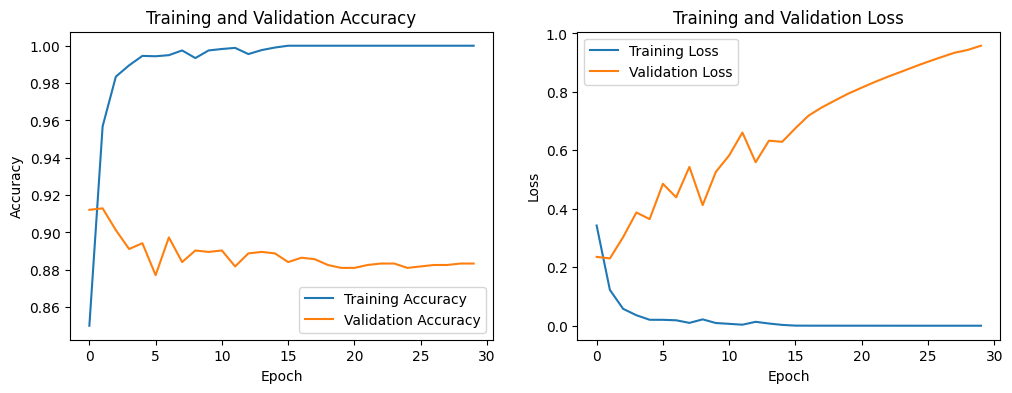

In [38]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(model_lstm_1_hist.history['accuracy'], label='Training Accuracy')
plt.plot(model_lstm_1_hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model_lstm_1_hist.history['loss'], label='Training Loss')
plt.plot(model_lstm_1_hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


- Berdasarkan grafik diatas kita bisa simpulkan bahwa model sangat overfit. Terlihat bahwa ada jarak yang lumayan besar antara training dan validation accuracy. Oleh karena itu saya akan menggunakan Transfer Learning pada model guna mengecilkan jarak tersebut.

## vii. ANN Training Improvement

### LSTM Model with Transfer Learning

In [40]:
# Download the Embedding Layer

url = 'https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1'

hub_layer = tf_hub.KerasLayer(url, output_shape=[128], input_shape=[], dtype=tf.string)

In [41]:
# Define input layer
input_text = Input(shape=[], dtype=tf.string)

# Add the hub layer
embedded_text = hub_layer(input_text)

# Reshape and add LSTM layers
reshaped = Reshape((128, 1))(embedded_text)
x = Bidirectional(LSTM(32, return_sequences=True))(reshaped)
x = Dropout(0.1)(x)
x = Bidirectional(LSTM(16))(x)
x = Dropout(0.1)(x)

# Output layer
output = Dense(2, activation='softmax')(x)

# Create model
model_lstm_2 = Model(inputs=input_text, outputs=output)

# Compile the model
model_lstm_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model_lstm_2_hist = model_lstm_2.fit(X_train, y_train_ohe, epochs=30, validation_split=0.2)


Epoch 1/30
161/161 [==============================] - 19s 79ms/step - loss: 0.6459 - accuracy: 0.6060 - val_loss: 0.5953 - val_accuracy: 0.6851
Epoch 2/30
161/161 [==============================] - 12s 74ms/step - loss: 0.5679 - accuracy: 0.7060 - val_loss: 0.5558 - val_accuracy: 0.7201
Epoch 3/30
161/161 [==============================] - 12s 77ms/step - loss: 0.5360 - accuracy: 0.7334 - val_loss: 0.5220 - val_accuracy: 0.7543
Epoch 4/30
161/161 [==============================] - 12s 74ms/step - loss: 0.5215 - accuracy: 0.7452 - val_loss: 0.5680 - val_accuracy: 0.7286
Epoch 5/30
161/161 [==============================] - 13s 81ms/step - loss: 0.5053 - accuracy: 0.7552 - val_loss: 0.5046 - val_accuracy: 0.7644
Epoch 6/30
161/161 [==============================] - 12s 76ms/step - loss: 0.4943 - accuracy: 0.7678 - val_loss: 0.5140 - val_accuracy: 0.7652
Epoch 7/30
161/161 [==============================] - 12s 74ms/step - loss: 0.4926 - accuracy: 0.7660 - val_loss: 0.5021 - val_accuracy:

### Plot Training Result with Transfer Learning

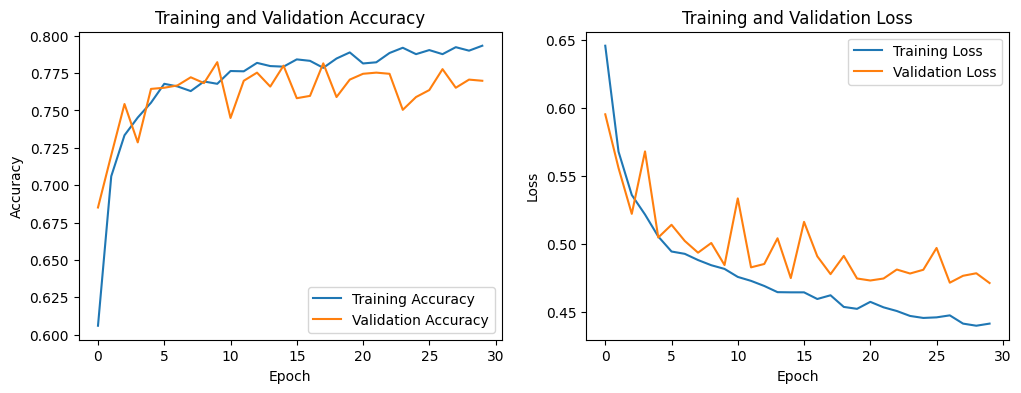

In [42]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(model_lstm_2_hist.history['accuracy'], label='Training Accuracy')
plt.plot(model_lstm_2_hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model_lstm_2_hist.history['loss'], label='Training Loss')
plt.plot(model_lstm_2_hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Berdasarkan grafik yang diatas, dapat disimpulkan bahwa:

- Model berhasil meningkatkan akurasi dan menurunkan loss selama proses training dengan menggunakan transfer learning.
- Model masih menunjukan sedikit overfit namun sudah lebih baik dari model sebelumnya.
- Nilai accuracy mengurang namun performa model meningkat.

## viii. Model Saving

In [44]:
# Save model
model_lstm_2.save('model.h5')  # Save the transfer learning model

## ix. Model Inference

Model inference ada pada file P2G7_fachry_inf.ipynb

## x. Pengambilan Kesimpulan

### EDA

#### KESIMPULAN

Kesimpulan dari analisis ini menunjukkan bahwa data dominasi pada rating positif dibandingkan rating negatif mencerminkan ketidakseimbangan data, yang berpotensi memengaruhi kinerja model dalam memprediksi rating dari ulasan pengguna, sehingga diperlukan langkah-langkah untuk melakukan databalancing. Namun dalam hal bisnis ini sangatlah baik karena lebih banyak rating positif menandakan bisnis berjalan dengan baik dan memuaskan majoritas pengunjung.

#### Rekomendasi

Dari hasil analisis dapat saya berikan beberapa rekomendasi bisnis :
- Tanggapi Ulasan Negatif: Aktif menanggapi dan menyelesaikan masalah yang diangkat dalam ulasan negatif dapat meningkatkan persepsi pelanggan dan menunjukkan bahwa hotel peduli terhadap pengalaman tamu.
- Mengadakan Survei Pelanggan: Lakukan survei untuk mendapatkan wawasan lebih dalam mengenai aspek yang disukai pelanggan dan area yang perlu diperbaiki, guna menyesuaikan layanan dengan harapan mereka.
- Program Loyalitas Pelanggan: Ciptakan program loyalitas untuk pelanggan yang telah memberikan ulasan positif, untuk meningkatkan retensi dan mendorong mereka kembali.

### Model

#### KESIMPULAN

- Model sebelum dilakukan transfer learning memiliki accuracy yang tinggi namun model cenderung overfitting.
- Setelah dilakukan transfer learning nilai accuracy model menurun namun jarak hasil train dan validation mengecil menghasilkan model yang lebih stabil.

#### REKOMENDASI

- Jika memiliki hardware yang lebih bagus dan waktu yang lebih banyak, bisa lebih luas dalam mengatur parameter pada model seperti text vector, word embedding, dan model architecturenya guna mengurangi overfitting.
- Pada data balancing bisa mencoba oversampling dengan menduplikat data minoritas dengan harapan semakin banyak data semakin detail model belajar.